# Solve the discretized linear convection equation with periodic boundary condition

The linear convection equation
$$
    \partial_t u + c \partial_x u = 0
$$
can be discretized, yielding
$$
    \partial_t u + A u = 0.
$$

For the linear convection equation with periodic boundary condition, discretized using the central scheme
$$
A = 
\dfrac{c}{2\Delta x}
\begin{bmatrix}
0  & 1 &   & & -1 \\
-1 & 0 & 1 & & \\
   & \ddots & \ddots & \ddots & \\
   & & -1 & 0 & 1 \\
1  & & & -1 & 0
\end{bmatrix}.
$$

When using the upwind scheme
$$
A = 
\dfrac{c}{\Delta x}
\begin{bmatrix}
1  &   &  & & -1 \\
-1 & 1 &  & & \\
   & \ddots & \ddots & & \\
   & & -1 & 1 &  \\
   & & & -1 & 1
\end{bmatrix}.
$$



In [18]:
import numpy as np
from scipy.integrate import solve_ivp
import pyutils as pu

## Timestep and Grids

$N = 2^{n}$

In [19]:
C = 10
D = 0.5
S = -1

# timestep
t = 2

# number of qubits for u
nqu = 8
nx = 2**nqu

## Initialization

In [20]:
L = 30

## nx
# Initialization
x = np.linspace(-L/2, L/2, num=nx, endpoint=False)

dx = L/nx

# Gaussian
#sigma = np.sqrt(1/2)
#mu = 0
#g = 1/sigma/np.sqrt(2.*np.pi) * np.exp(-np.square(x-mu)/(2*np.square(sigma)))

sigma = np.sqrt(1/2)
mu = -10
g = np.exp(-np.square(x-mu))

for i, v in enumerate(g):
    if np.abs(x[i] - mu) > 5*sigma:
        g[i] = 0

#g = np.exp(-np.square(x))

u_init = g

### Convection, central difference scheme with left inlet

$2^n$ points

$$
    \bm{A} = 
    \dfrac{c}{2\Delta x}
    \begin{bmatrix}
    0  & 1 &   & & -1 \\
    -1 & 0 & 1 & & \\
       & \ddots & \ddots & \ddots & \\
       & & -1 & 0 & 1 \\
    1  & & & -1 & 0
    \end{bmatrix}.
$$

In [21]:
AC = np.zeros((nx, nx))
for i in range(nx-1):
    AC[i,i+1] = 1
    AC[i+1,i] = -1
AC[0,-1] = -1
AC[-1,0] = 1
AC = AC * C / (2*dx)

### Diffusion, central difference scheme

$2^n$ points

$$
    \bm{A} = 
    \dfrac{D}{\Delta x^2}
    \begin{bmatrix}
    2  & -1 &   & & -1 \\
    -1 & 2 & -1 & &   \\
       & \ddots & \ddots & \ddots & \\
       & & -1 & 2 & -1 \\
    -1 & & & -1 & 2  \\
    \end{bmatrix}.
$$

In [22]:
AD = np.zeros((nx, nx))
for i in range(nx-1):
    AD[i,i+1] = -1
    AD[i+1,i] = -1
    AD[i,i] = 2
AD[-1,-1] = 2
AD[0,-1] = -1
AD[-1,0] = -1
AD = AD * D / np.square(dx)

### Reaction

In [23]:
AS = np.eye(nx)
AS *= -S

In [24]:
A = AC + AD + AS
#A = AD

def source(t, y):
    return np.matmul(-A, y)

## Run

In [25]:
tnow = 0
u = u_init.copy()

itC = C / dx
itD = D / np.square(dx)
dt = 0.1 / max(itC, itD)
print(dt)

while(tnow < t):

    if t - tnow < dt:
        dt = t - tnow

    du = np.matmul(-A*dt, u)

    u += du

    tnow += dt

0.0011718750000000002


In [26]:
sol = solve_ivp(source, [0, t], u_init, method='RK23', t_eval=np.linspace(0, t, num=21))

## Plot

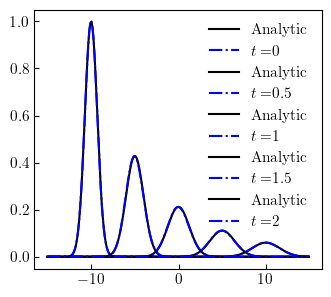

In [35]:
pc = pu.fig.PlotConfig()

fig, ax = pc.get_simple()

#ax.plot(x, u_init, '-k', label='t=0')

#ax.plot(x, u, '--r', label='Classical')

for i in range(0,5):

    time = sol.t[5*i]

    ut = np.exp(-np.square(x-mu-C*time)/(1+4*D*time)) / np.sqrt(1+4*D*time) * np.exp(S*time)
    ax.plot(x, ut, '-k', label = 'Analytic')

    ax.plot(x, sol.y[:,5*i], '-.b', label='$t=${:g}'.format(time))

ax.legend(frameon=False)

In [34]:
np.savez('1DPeriodicDiscretizedFiniteDifferenceC{:g}D{:g}S{:g}L{:g}nx{:g}'.format(C,D,S,L,nqu),
         x = x, t = sol.t, y = sol.y)